In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/')

In [ ]:
from InterpNN1D import *
import matplotlib.pyplot as plt ###Should print "cuda" otherwise something is wrong

Device: cuda
Final 1D Interp NN


In [ ]:
###Setup the parameter for our problem
n_controls = 2
N = 11
n_steps = 50
n_qubits=1

###PAULIS are written in the NN class, do not overwrite
H_drives = np.array([PAULIS["X"],PAULIS["Y"]],dtype='cfloat')
gpu_H_drives = torch.tensor(H_drives).to(device)  ###Always pass these to functions, these are stored on gpu


def excitation(theta):
    return torch.linalg.matrix_exp(-1j/2 * theta * torch.tensor(PAULIS["Z"]))

def gpu_excitation(theta):
    return torch.linalg.matrix_exp(-1j/2 * theta * torch.tensor(PAULIS["Z"]).to(device)) ###Always pass these to functions, these are stored on gpu

dt = 0.2 ###Timestep

theta_list = torch.tensor(np.linspace(0,2*pi,5000),dtype=float).to(device)

In [ ]:
###Create a model for pretraining and training
pretraining_model = InterpolationNetwork1D(
    N = N, ###Number of theta values sampled by PICO
    layers=1, ###Number of hidden layers
    width = 50, ###Number of nodes in each hidden layer
    dt=dt, ###Timestep
    n_steps = n_steps, ###Number of timesteps
    operator = gpu_excitation, ###Operator to use
    H_drives=gpu_H_drives, ###Drive terms. For us, no drift
)
pretraining_path = "/content/drive/MyDrive/XYControlRZ/XYControlRZGood.csv"

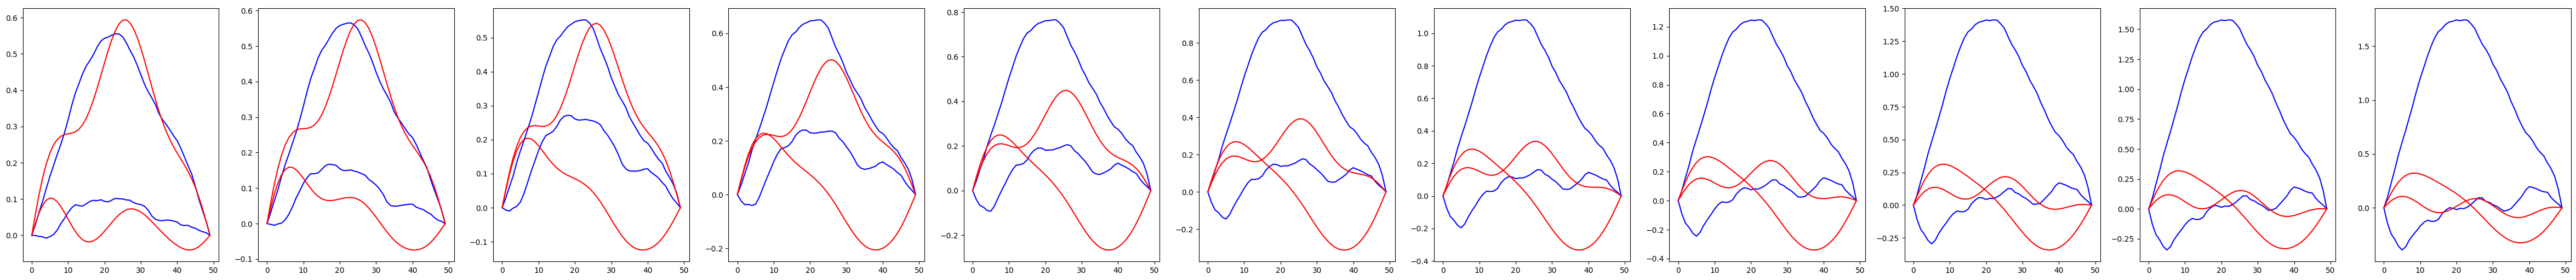

In [ ]:

fig, ax = plt.subplots(1,N,figsize=(60,6))
model_controls,pretrain_controls = pretraining_model.get_comparison_controls(pretraining_path) ###Get the model/pretrain controls
for i in range(N):
    ax[i].plot(model_controls[i],color='blue')
    ax[i].plot(pretrain_controls[i],color='red')

In [ ]:
###Export the pretraining model (Make sure you have the right folder)
torch.save(pretraining_model.model.state_dict(), "/content/drive/MyDrive/XYControlRZ/BeforePretrained.pt")

In [ ]:

pretrain_loss=pretraining_model.pretrain(
    pretraining_path = pretraining_path, ###Path of pretraining data
    lr = 1e-3, ###Learnrate, defaults to 1e-3 (does not need to be set)
    iters=50000,#10**6//2,###Optimization iterations, defaults to 5*10**5 (does not need to be set)
    thresh=1e-7
)

Epochs: 0 Loss: 0.22161374986171722
-------------------
Epochs: 1000 Loss: 4.29070096288342e-05
-------------------
Epochs: 2000 Loss: 1.495475498813903e-05
-------------------
Epochs: 3000 Loss: 3.2251118682324886e-05
-------------------
Epochs: 4000 Loss: 2.79193336609751e-05
-------------------
Epochs: 5000 Loss: 5.576155217568157e-06
-------------------
Epochs: 6000 Loss: 8.740378689253703e-05
-------------------
Epochs: 7000 Loss: 4.513633030001074e-06
-------------------
Epochs: 8000 Loss: 3.724966063600732e-06
-------------------
Epochs: 9000 Loss: 2.473210543030291e-06
-------------------
Epochs: 10000 Loss: 1.4876070508762496e-06
-------------------
Epochs: 11000 Loss: 7.537300461990526e-06
-------------------
Epochs: 12000 Loss: 1.9358742520125816e-06
-------------------
Epochs: 13000 Loss: 2.7353519271855475e-06
-------------------
Epochs: 14000 Loss: 8.002173217391828e-07
-------------------
Epochs: 15000 Loss: 6.480957495114126e-07
-------------------
Epochs: 16000 Loss: 6

Text(0.5, 1.0, 'Pretraining Loss')

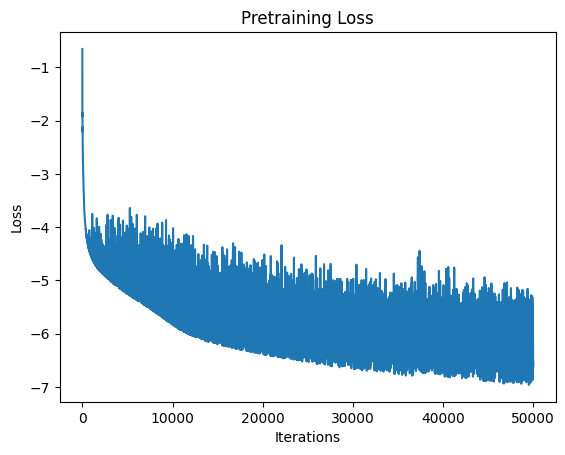

In [ ]:
plt.plot(np.log10(np.array(pretrain_loss))) ###Plot the pretraining loss
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Pretraining Loss")

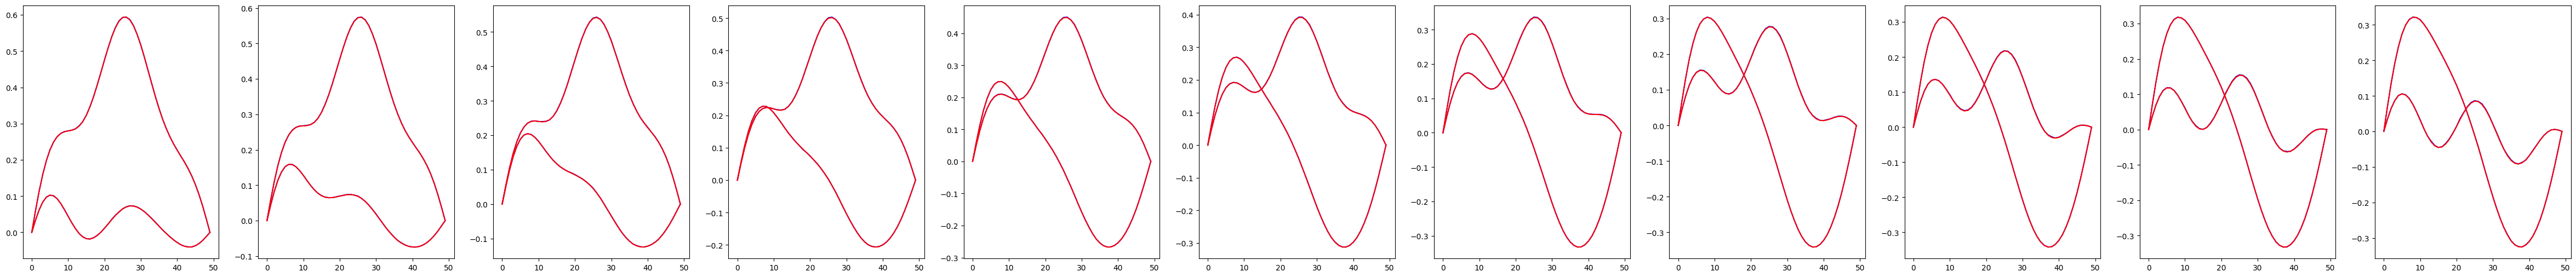

In [ ]:
fig, ax = plt.subplots(1,N,figsize=(60,6))
model_controls,pretrain_controls = pretraining_model.get_comparison_controls(pretraining_path) ###Get the model/pretrain controls
for i in range(N):
    ax[i].plot(model_controls[i],color='blue')
    ax[i].plot(pretrain_controls[i],color='red')

In [ ]:
model_infid,pretrain_infid=pretraining_model.get_comparison_samples(pretraining_path) ###Get the Infidelities for the model and the pretraining data
print(f"Model: {model_infid} \n Pretraining Data: {pretrain_infid}")

Model: tensor([1.4234e-04, 1.2845e-04, 3.8290e-04, 2.4951e-04, 2.9981e-05, 2.5725e-04,
        1.4120e-04, 8.4996e-05, 2.2423e-04, 5.1498e-05, 8.8394e-05],
       device='cuda:0', grad_fn=<MaximumBackward0>) 
 Pretraining Data: tensor([1.3053e-04, 1.1587e-04, 3.2926e-04, 1.6904e-04, 5.6028e-06, 2.3854e-04,
        1.3334e-04, 7.9751e-05, 2.2781e-04, 5.3644e-05, 7.1108e-05])


Text(0.5, 1.0, 'Only Pretrained Log Infidelity')

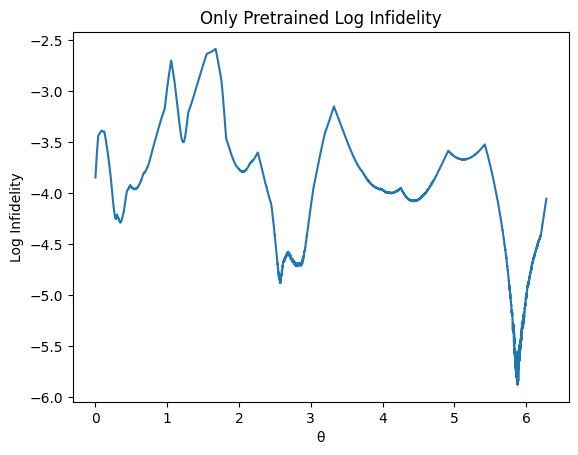

In [ ]:
###Logplot infidelity
log_infidelity_vals=pretraining_model.infid_data(theta_list)
plt.plot(torch.Tensor.cpu(theta_list).detach().numpy(),torch.Tensor.cpu(log_infidelity_vals).detach().numpy(),label='pretrained')
plt.xlabel('θ')
plt.ylabel('Log Infidelity')
plt.title("Only Pretrained Log Infidelity")

In [ ]:
###Export the pretraining model (Make sure you have the right folder)
torch.save(pretraining_model.model.state_dict(), "/content/drive/MyDrive/XYControlRZ/JustPretrained.pt")

In [ ]:
###Train the model
train_losses,test_losses=pretraining_model.train(
    theta_list=theta_list,
    lr=5e-4,  ###Learn Rate, does not need to be set (defaults to 5e-5)
    iters=10**3//2, ###Iterations, does not need to be set(defaults to 10**5)
    train_size=500,test_size=4500,batch_size=50,c=1e-5
)

Epoch: 0
Total Loss: 0.0007451320998370647
Train Size: 500
-------------------
Epoch: 100
Total Loss: 9.231876902049407e-05
Train Size: 500
-------------------
Epoch: 200
Total Loss: 9.052820132637862e-06
Train Size: 500
-------------------
Epoch: 300
Total Loss: 1.9058294128626585e-05
Train Size: 500
-------------------
Epoch: 400
Total Loss: 5.748240710090613e-06
Train Size: 500
-------------------


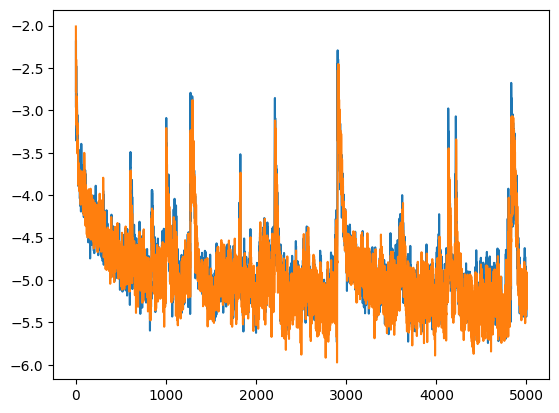

In [ ]:
plt.plot(np.log10(train_losses))
plt.plot(np.log10(test_losses))

Text(0.5, 1.0, 'Pretrained Log Infidelity')

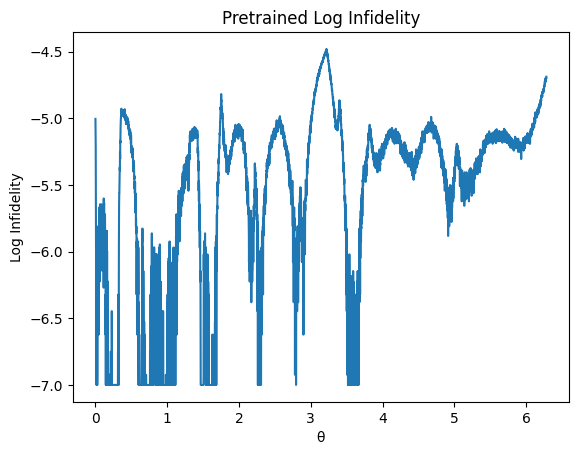

In [ ]:
###Logplot infidelity
log_infidelity_vals=pretraining_model.infid_data(theta_list)
plt.plot(torch.Tensor.cpu(theta_list).detach().numpy(),torch.Tensor.cpu(log_infidelity_vals).detach().numpy(),label='pretrained')
plt.xlabel('θ')
plt.ylabel('Log Infidelity')
plt.title("Pretrained Log Infidelity")

In [ ]:
###Make and plot a new model, this will not be pretrained
new_model = InterpolationNetwork1D(
    N = N, ###Number of theta values sampled by PICO
    layers=1, ###Number of hidden layers
    width = 50, ###Number of nodes in each hidden layer
    dt=dt, ###Timestep
    n_steps = n_steps, ###Number of timesteps
    operator = gpu_excitation, ###Operator to use
    H_drives=gpu_H_drives, ###Drive terms. For us, no drift
)
###Train the model
new_train_losses,new_test_losses=new_model.train(
    theta_list=theta_list,
    lr=5e-4,  ###Learn Rate, does not need to be set (defaults to 5e-5)
    iters=10**3//2, ###Iterations, does not need to be set(defaults to 10**5)
    train_size=500,test_size=4500,batch_size=50,c=1e-5
)

Epoch: 0
Total Loss: 0.3568141460418701
Train Size: 500
-------------------
Epoch: 100
Total Loss: 7.88034449215047e-05
Train Size: 500
-------------------
Epoch: 200
Total Loss: 8.715665171621367e-05
Train Size: 500
-------------------
Epoch: 300
Total Loss: 7.056476169964299e-05
Train Size: 500
-------------------
Epoch: 400
Total Loss: 7.016546442173421e-05
Train Size: 500
-------------------


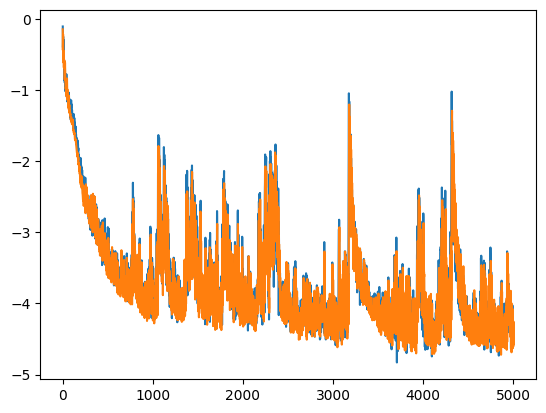

In [ ]:
plt.plot(np.log10(new_train_losses))
plt.plot(np.log10(new_test_losses))

Text(0.5, 1.0, 'Training Losses')

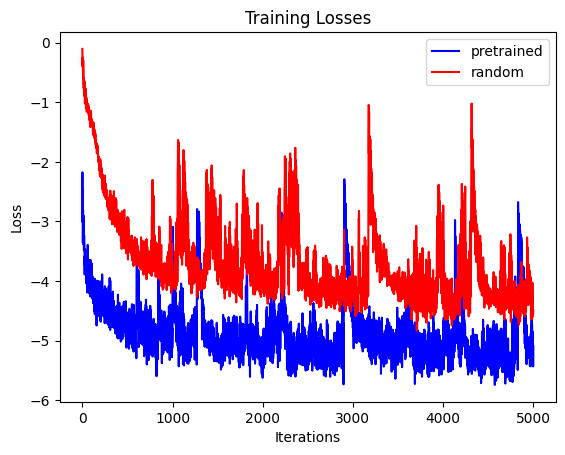

In [ ]:
plt.plot(np.log10(np.array(train_losses)),color='blue',label='pretrained')
plt.plot(np.log10(np.array(new_train_losses)),color='red',label='random')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.title("Training Losses")

Text(0.5, 1.0, 'Test Losses')

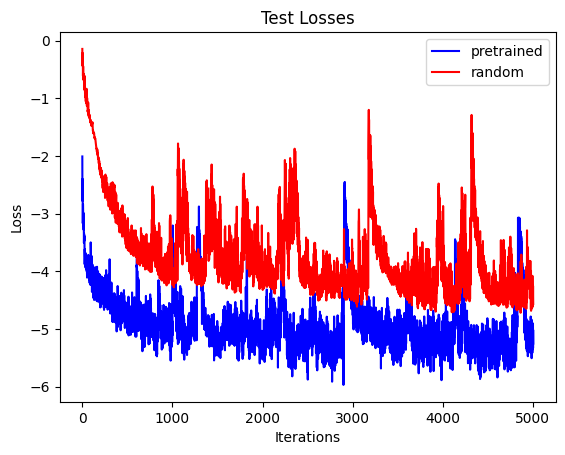

In [ ]:
plt.plot(np.log10(np.array(test_losses)),color='blue',label='pretrained')
plt.plot(np.log10(np.array(new_test_losses)),color='red',label='random')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.title("Test Losses")

Text(0.5, 1.0, 'Log Infidelity')

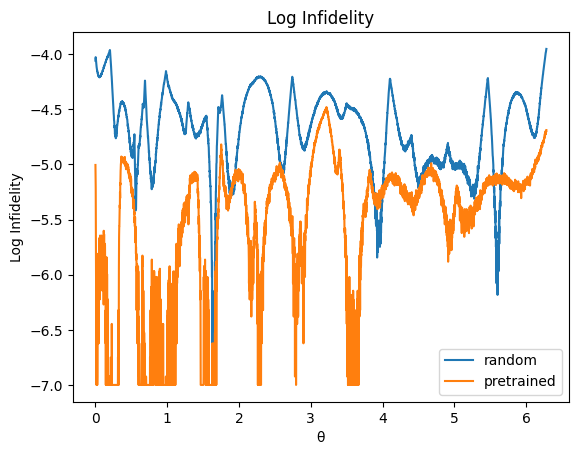

In [ ]:
log_infidelity_vals=new_model.infid_data(theta_list)
plt.plot(torch.Tensor.cpu(theta_list).detach().numpy(),torch.Tensor.cpu(log_infidelity_vals).detach().numpy(),label='random')
log_infidelity_vals2=pretraining_model.infid_data(theta_list)
plt.plot(torch.Tensor.cpu(theta_list).detach().numpy(),torch.Tensor.cpu(log_infidelity_vals2).detach().numpy(),label='pretrained')
plt.legend()
plt.xlabel('θ')
plt.ylabel('Log Infidelity')
plt.title("Log Infidelity")

In [ ]:
print(f"Pretrained Infidelity Loss: {pretraining_model.infid_loss(theta_list)}")

Pretrained Infidelity Loss: 5.551684353122255e-06


In [ ]:
print(f"New Infidelity Loss: {new_model.infid_loss(theta_list)}")

New Infidelity Loss: 2.706444138311781e-05


In [ ]:
###EXPORT ALL DATA
torch.save(pretraining_model.model.state_dict(), "/content/drive/MyDrive/XYControlRZ/Pretrained.pt")
torch.save(new_model.model.state_dict(), "/content/drive/MyDrive/XYControlRZ/NonPretrained.pt")
train_data = {'train': train_losses, 'new_train':new_train_losses }
test_data = {'test': test_losses, 'new_test':new_test_losses }
train_loss_df = pd.DataFrame(data=train_data)
test_loss_df = pd.DataFrame(data=test_data)
train_loss_df.to_csv("/content/drive/MyDrive/XYControlRZ/Train_Loss")
test_loss_df.to_csv("/content/drive/MyDrive/XYControlRZ/Test_Loss")

In [ ]:
###Always Include This to stop session
from google.colab import runtime
runtime.unassign()